# Imminent ICU Admission Classifier with MLH Notes only using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pickle
import scipy

import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scikitplot.metrics import *

from utils.data_utils import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *

In [2]:
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/lr'),
 'figdir': PosixPath('../data/workdir/figures'),
 'vectordir': PosixPath('../data/workdir/vectordir'),
 'dataset_csv': PosixPath('../data/unstructured_proc.csv'),
 'threshold': 0.31}

## Functions

In [3]:
def compute_cloud(scores, idx2tok, n_tokens=50, min_len=4):
  sorted_idxs = np.argsort(scores)  
  p = re.compile('^[a-z\s]+$')
  tokens = []
  trim_scores = []

  for idx in sorted_idxs:
    token = idx2tok[idx].lower()
    if len(token) > min_len and p.match(token):
      tokens.append(token)
      trim_scores.append(scores[idx] * -1)
      
  pos_dict = {k: v for k, v in zip(tokens[:n_tokens], trim_scores[:n_tokens])}
  neg_dict = {k: v for k, v in zip(tokens[-n_tokens:], trim_scores[-n_tokens:])}
  
  pos_cloud = WordCloud(width=400, height=400, background_color='white', max_font_size=60, relative_scaling=0.5).generate_from_frequencies(pos_dict)
  neg_cloud = WordCloud(width=400, height=400, background_color='white', max_font_size=60, relative_scaling=0.5).generate_from_frequencies(neg_dict)
  
  return pos_cloud, neg_cloud

## Load Data

In [4]:
seed = 643
notes_df = pd.read_csv(args.dataset_csv, usecols=['hadm_id', 'note', 'imi_adm_label'])
notes_df = notes_df[notes_df['imi_adm_label'] != -1].reset_index(drop=True)
notes_df.shape

(116400, 3)

## Single Model Development

In [5]:
df = set_group_splits(notes_df.copy(), group_col='hadm_id', seed=seed)

train_df = df[df['split'] == 'train'][['note', 'imi_adm_label']]
test_df = df[df['split'] == 'test'][['note', 'imi_adm_label']]

g = train_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in training set:{(g[1]/g.sum())*100:0.1f}%")
g = test_df.groupby(['imi_adm_label']).size().to_numpy()
print(f"Prevalence of positive class in test set:{(g[1]/g.sum())*100:0.1f}%")

Prevalence of positive class in training set:3.3%
Prevalence of positive class in test set:3.6%


In [6]:
# vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=60_000)
# x_train = vectorizer.fit_transform(train_df['note'])
# x_test = vectorizer.transform(test_df['note'])

# with open(args.vectordir/'bigram_643.pkl', 'wb') as f:
#   pickle.dump(vectorizer, f)
#   pickle.dump(x_train, f)
#   pickle.dump(x_test, f)

with open(args.vectordir/'bigram_643.pkl', 'rb') as f:
  vectorizer = pickle.load(f)
  x_train = pickle.load(f)
  x_test = pickle.load(f)
  
y_train,y_test = train_df['imi_adm_label'], test_df['imi_adm_label']
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((99631, 60000), (16769, 60000), (99631,), (16769,))

In [7]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(x_train, y_train)

prob = clf.predict_proba(x_test)
pos_prob = prob[:, 1]

labels = ['Delayed', 'Imminent']
label_test = [labels[i] for i in y_test]

Text(0, 0.5, 'Sensitivity')

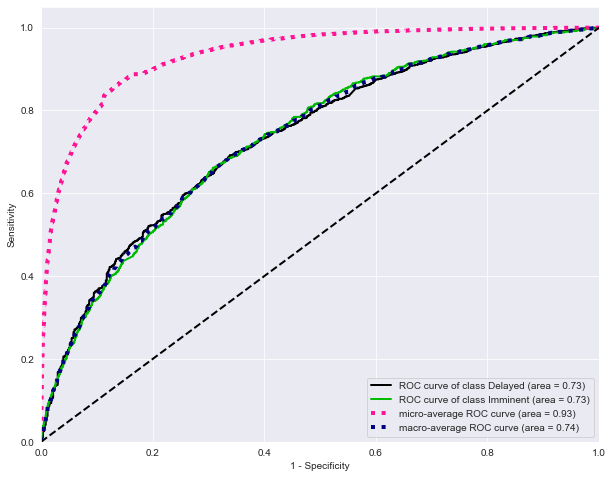

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(label_test, prob, title='', ax=ax)
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

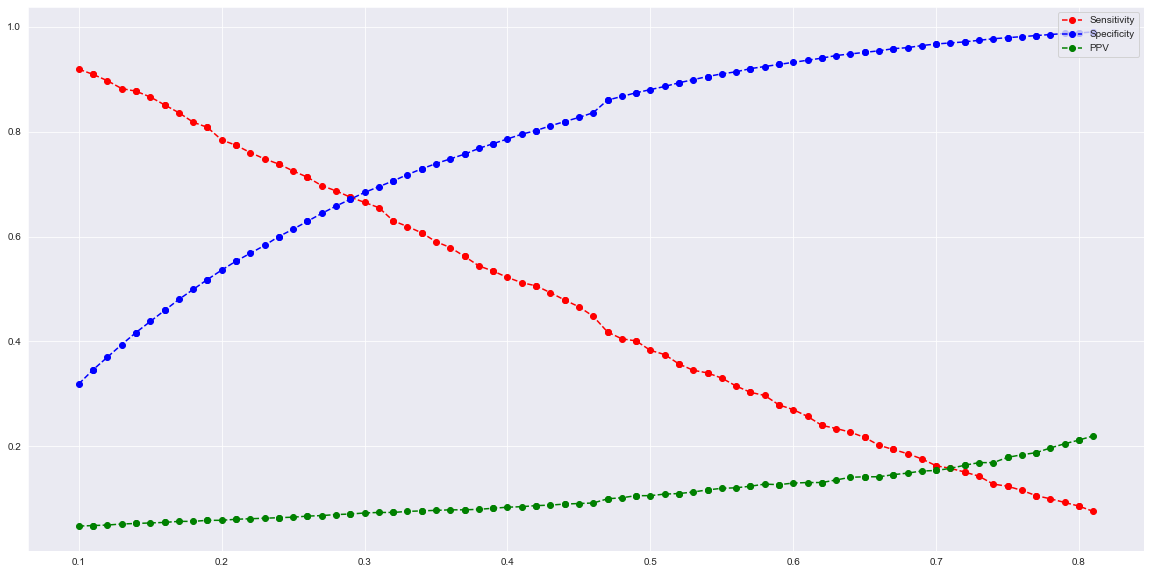

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100)

In [12]:
fig.savefig(args.figdir/f'lr_unstructured_metrics_vary.pdf', dpi=300, box_inches='tight', pad_inches=0)

Best Youden Threshold = 0.31


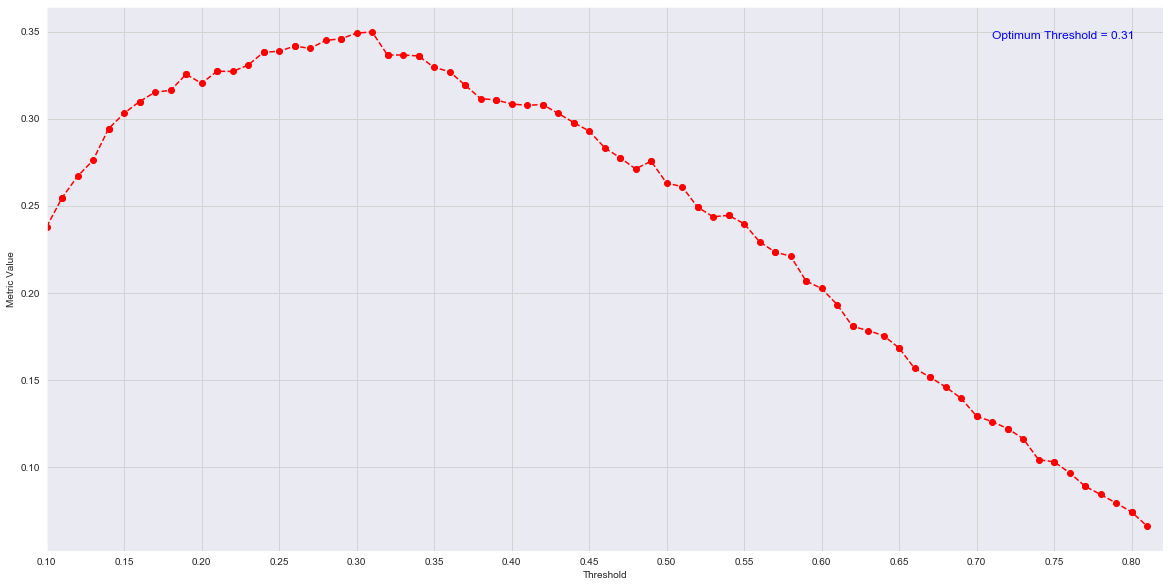

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
best_threshold = plot_thresh_metric(ax, y_test, pos_prob, lower=0.1, upper=0.81, n_vals=100, show_f1=False)
ax.text(0.71, ax.get_ylim()[1]*0.95, f'Optimum Threshold = {best_threshold[0]}', fontsize=12, color='b')
print(f"Best Youden Threshold = {best_threshold[0]}")

In [13]:
fig.savefig(args.figdir/f'lr_unstructured_youden.pdf', dpi=300, box_inches='tight', pad_inches=0)

In [11]:
threshold = 0.31
pred = (pos_prob > threshold).astype(np.int64)
label_preds = [labels[i] for i in pred]
cm = confusion_matrix(y_test, pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, pos_prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'threshold': threshold,
}
metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.655
specificity,0.695
ppv,0.074
npv,0.982
f1,0.133
auroc,0.735
threshold,0.310


In [ ]:
# idx2tok = {v: k for k, v in vectorizer.vocabulary_.items()}
# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# pos_cloud, neg_cloud = compute_cloud(clf.coef_[0], idx2tok, n_tokens=250)
# ax[0].imshow(neg_cloud)
# ax[0].axis('off')
# ax[0].set_title('Delayed ICU Admission')
# ax[1].imshow(pos_cloud)
# ax[1].axis('off')
# ax[1].set_title('Imminent ICU Admission')

# if save:
#   fig.savefig(args.figdir/f'wordcloud.pdf', dpi=300)

## Metrics

In [16]:
with open(args.workdir/f'preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  probs = pickle.load(f)
  preds = pickle.load(f)

bam = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])
bam.get_main_avg_metrics(defn=True)

,Value,Definition
sensitivity,0.620,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.697,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.067,"When it PREDICTS YES, how often is it correct?"
auroc,0.720,Indicates how well the model is capable of distinguishing between classes


In [18]:
bam.get_main_avg_metrics(conf=0.95)

,Mean,Lower,Upper
sensitivity,0.620,0.614,0.627
specificity,0.697,0.695,0.700
ppv,0.067,0.065,0.068
auroc,0.720,0.716,0.723


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, probs)

if save:
  fig.savefig(args.figdir/f'{args.expt}_mean_roc.pdf', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
plot_cm(ax, bam.cm_avg, ['Delayed', 'Imminent'])

if save:
  fig.savefig(args.figdir/f'{args.prefix}_mean_cm.pdf', dpi=300)